# About this notebook

The `scipy` software package is the go-to tool for math, statistics and basic data science, when `numpy` functions are not enough. Most `scipy` functionality can be used with numbers as well as `numpy` arrays.


https://www.scipy.org/index.html

"SciPy (pronounced “Sigh Pie”) is a Python-based ecosystem of open-source software for mathematics, science, and engineering. SciPy is a collection of mathematical algorithms and convenience functions built on the NumPy extension of Python. It adds significant power to the interactive Python session by providing the user with high-level commands and classes for manipulating and visualizing data."

`scipy` is one of the most important software packages for standard data analysis (that is not machine learning). In this notebook, you'll learn about a couple of its math, analysis and statistics functions, but there is much more to discover on the scipy webpage.

# Scipy

# Import packages

In [3]:
# different ways to import packages
import scipy # import the package 'scipy'
from scipy import stats
import numpy as np # import the package numpy as abbreviation 'np'
from matplotlib import colors # import class 'colors' from the matplotlib package
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt # import class pyplot of matplotlib as abbrev. 'plt'


... -> how you need to import the package, classes, functions, ... depends a bit on the package itself. When in doubt, just google it :) 'stackoverflow' usually knows the answer!

## Integration

In [4]:
from scipy import integrate

# first, we define ascending x values
x = np.linspace(0, 1.5*np.pi)
# ... and get the bounds (first and last element)
x0, x1 = x[0], x[-1]

print(integrate.quad(np.sin, x0, x1)) # quad returns integral and error. beware of floating-point precision!

(1.0000000000000002, 3.334366076909447e-14)


You can take a look at the function docstring in:
- API reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
- running `?integrate.quad` in the notebook cell
- running `help(integrade.quad)` in the notebook cell

The docsting example:
```
quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50, complex_func=False)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate. If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
...
    a : float
        Lower limit of integration (use -numpy.inf for -infinity).
    b : float
        Upper limit of integration (use numpy.inf for +infinity).
```

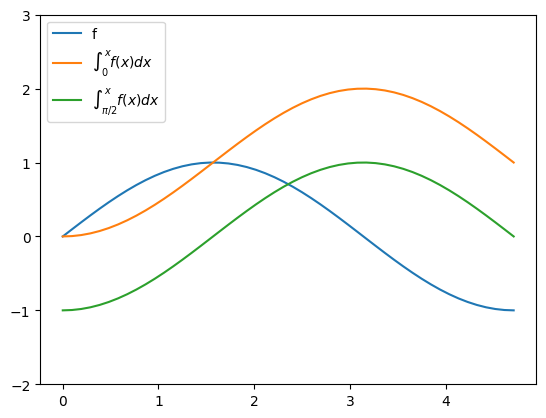

In [5]:
# define integrated function of f:

# the decorator @np.vectorize makes sure that we can give
# a numpy array to fint for fast evaluation

# this is needed, because x in .quad can only be a number,
# not an array!

@np.vectorize
def fint(x, x0=0):
    return integrate.quad(np.sin, x0, x)[0]

plt.plot(x, np.sin(x), label="f")
plt.plot(x, fint(x), label=r"$\int_0^x f(x) dx$")
plt.plot(x, fint(x, x0=np.pi/2), label=r"$\int_{\pi/2}^x f(x) dx$")
plt.ylim(-2, 3)
plt.legend()

**Tasks:**
- See what happens when you remove the decorator.
- Implement a version of `fint_vectorized` function, which accepts `x` argument as a numpy array.

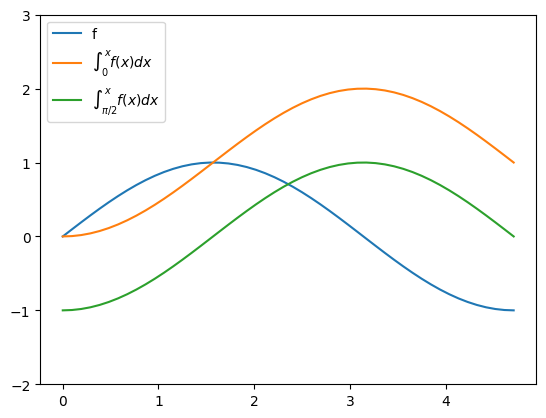

In [9]:
def fint_vectorized(x, x0=0):
    solution = [integrate.quad(np.sin, x0, xi)[0] for xi in x]
    return solution

plt.plot(x, np.sin(x), label="f")
plt.plot(x, fint_vectorized(x), label=r"$\int_0^x f(x) dx$")
plt.plot(x, fint_vectorized(x, x0=np.pi/2), label=r"$\int_{\pi/2}^x f(x) dx$")
plt.ylim(-2, 3)
plt.legend()

## Fit a function to data points
This is a x-y data fit using a function y = f(x)
Example: Measuring the voltage $U$ at a resistor for different currents $I$.
Now you want to infer the resistance $R$.

In [10]:
from scipy.optimize import curve_fit

In [11]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize._minpack_py:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``.
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, and each element should be float
        convertible if it is an array like object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional

### Linear function

In [12]:
def fit_func(I, R, offset):
    ''' U = R * I + offset '''
    return R * I + offset

fit: [2.99332158 0.95047442]
covariance: [[ 0.01479678 -0.16250375]
 [-0.16250375  2.24323784]]


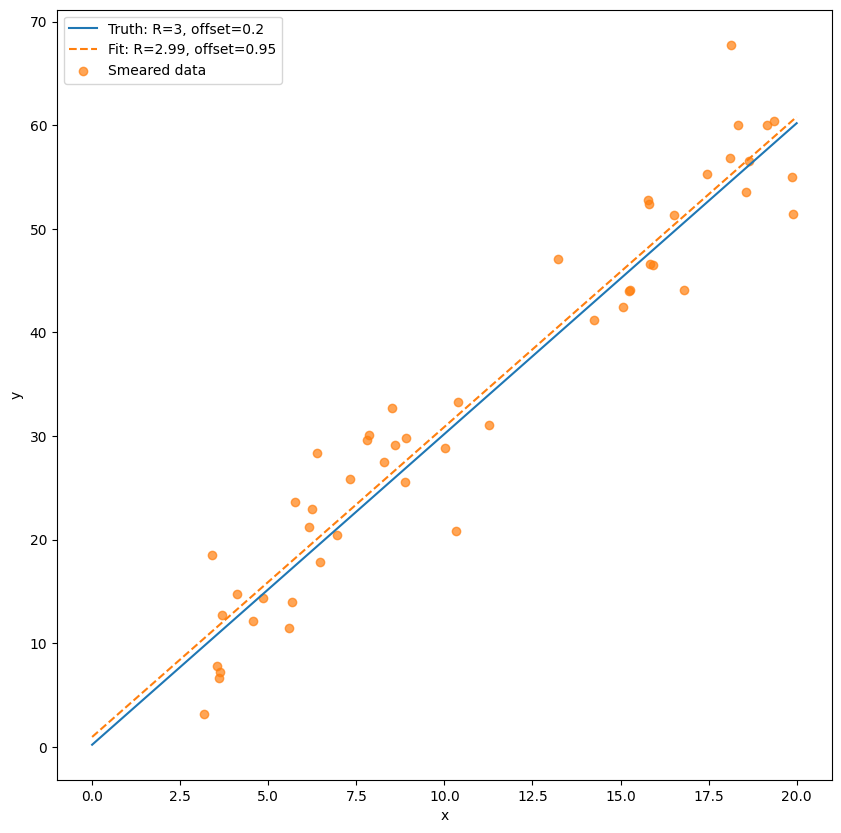

In [13]:
# generate some noisy data set
num = 50
xmin = 3
xmax = 20
# randomly sampled data in x coordinate
# (maybe your control of the current is kind of bad... :D)
x = np.random.uniform(xmin, xmax, num)
R = 3
offset = 0.2
# calculate the corresponding "true" y value
# and smear it with a gaussian to add "noise" and a systematic error

y_rand = fit_func(x, R=R, offset=offset) + stats.norm.rvs(
    loc=0.5, scale=5, size=num)
# this noise is represented by the width (scale)
# and the systematic error is represented by the mean (loc)

# you also can provide some first guess for the parameters (p0)
fit, cov = curve_fit(fit_func, x, y_rand, p0=[1.2, 2.8])
# returns fit parameters and covariance
print("fit:", fit)
print("covariance:", cov)
# ideally, you want to achieve small values on the off-diagonal,
# because otherwise your parameters are correlated
# see further below for a hint how to solve this

plt.figure(figsize=(10, 10))
xspace = np.linspace(0, xmax)
plt.plot(
    xspace, fit_func(xspace, R=R, offset=offset),
     label="Truth: R={}, offset={}".format(R, offset)
     )
line = plt.plot(
    xspace, fit_func(xspace, *fit),
     ls="--",
      label=f"Fit: R={fit[0]:1.2f}, offset={fit[1]:1.2f}"
      )
plt.scatter(x, y_rand, alpha=0.7, label="Smeared data", color=line[0].get_color())
plt.ylabel("y")
plt.xlabel("x")
plt.legend(loc=2)


### Exponential function

In [14]:
# this function has 2 free parameters (a, b)
def exponential_fit_func(x, a, b):
    return np.exp(a + b * x)

fit: [1.15141489 0.10279951]
covariance: [[ 4.62930741e-03 -6.37204572e-04]
 [-6.37204572e-04  9.72656709e-05]]


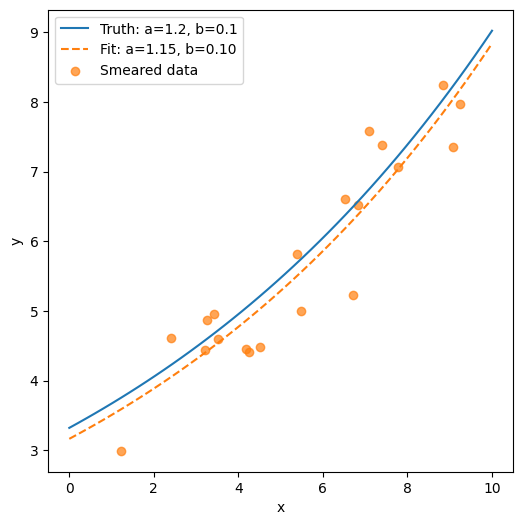

In [15]:
# generate some noisy data set
num = 20
xmin = 1
xmax = 10
# randomly sampled data in x coordinate
x = np.random.uniform(xmin, xmax, num)
a = 1.2
b = 0.1
# calculate the corresponding "true" y value
# and smear it with a gaussian to add "noise"
y_rand = exponential_fit_func(x, a, b) + stats.norm.rvs(scale=0.5, size=num)
# this noise is represented by the width (scale)

# you also can provide some first guess for the parameters (p0)
# now we need three parameters
fit, cov = curve_fit(exponential_fit_func, x, y_rand, p0=[1., 0.2])
# returns fit parameters and covariance
print("fit:", fit)
print("covariance:", cov)
# ideally, you want to achieve small values on the off-diagonal,
# because otherwise your parameters are correlated
# see further below for a hint how to solve this

plt.figure(figsize=(6, 6))
xspace = np.linspace(0, xmax)
plt.plot(
    xspace, exponential_fit_func(xspace, a, b),
     label=f"Truth: a={a}, b={b}"
     )
line = plt.plot(
    xspace, exponential_fit_func(xspace, *fit),
     ls="--",
      label=f"Fit: a={fit[0]:1.2f}, b={fit[1]:1.2f}"
      )
plt.scatter(x, y_rand, alpha=0.7, label="Smeared data", color=line[0].get_color())
plt.ylabel("y")
plt.xlabel("x")
plt.legend(loc=2)

# to show the exp shape, you can use a logarithmic axis
# plt.yscale("log")


## Interpolations

1.1195227066744167
1.2353755311711712
3.5932064847544325


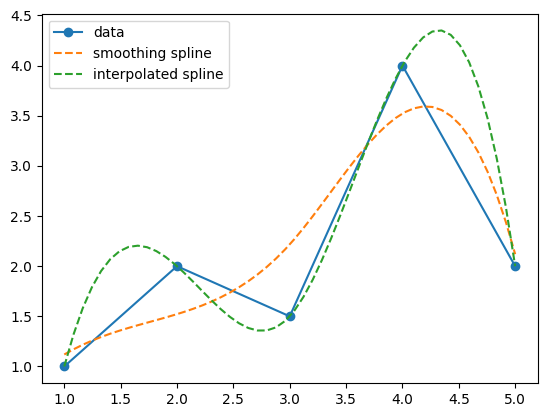

In [16]:
from scipy import interpolate
# some data points in x and y
x = [1,2,3,4,5]
y = [1,2,1.5,4,2]

# we call some of the Spline classes of the interpolate package of scipy
spl = interpolate.UnivariateSpline(x, y, k=3, s=1) # this is a smoothing spline
spl2 = interpolate.InterpolatedUnivariateSpline(x, y, k=3) # this is an interpolation spline
# they return a function

print(spl(1)) # you can call them like a normal function
print(spl(1.2))
print(spl(4.2))

# ... and we can plot the results
# first, the raw data
plt.plot(x, y, "o-", label="data")

# then, we generate some sequential x values to evaluate the splines
xi = np.linspace(1,5)
# .. then we plot the evaluated splines
plt.plot(xi, spl(xi), "--", label="smoothing spline") # spline doesn't need to run through data points
plt.plot(xi, spl2(xi), "--", label="interpolated spline") # spline interpolates between data points, no smoothing
plt.legend()

**Tasks:**
- Calculate the integral between 1.0 and 5.0 of interpolated splines

Hint: check available methods of Spline classes

In [20]:
def fint(f, x, x0=0):
    return integrate.quad(f, x0, x)[0]

print(fint(f=spl2, x0=1.0, x=5.0))

print(spl2.integral(1.0, 5.0))

10.0
10.0


## Statistical functions

Example: poisson and normal distributions

Poisson: $f(k | λ) = λ^k \cdot \exp(-λ) / k!$ for k \in {0, 1,..., ∞}$

Normal: $f(x | \mu, \sigma) = 1/\sqrt(2 \pi σ) \exp(- (x-\mu)^2 / 2σ^2  $

In [21]:
from scipy import stats
# there are LOTS AND LOTS of statistical distributions implemented in the stats package

In [25]:
P = stats.poisson(3.2) # generate probability mass function with lambda = 3.2

print(P.pmf(0)) # evaluate PMF for k = 0, PMF: f(x)=P[X=x]
print(P.cdf(1)) # evaluate CDF for k = 1


0.04076220397836621
0.17120125670913808


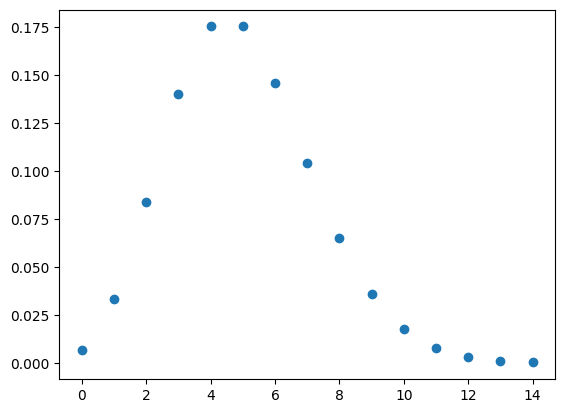

In [23]:
# visualization
P = stats.poisson(5)
ks = np.arange(15)
pmf_viz = P.pmf(ks)

plt.plot(ks, pmf_viz, marker="o", lw=0)

(array([ 13.,  29., 102., 190., 223., 205., 135.,  67.,  26.,  10.]),
 array([-0.75890823,  0.42165121,  1.60221066,  2.7827701 ,  3.96332955,
         5.14388899,  6.32444843,  7.50500788,  8.68556732,  9.86612677,
        11.04668621]),
 <BarContainer object of 10 artists>)

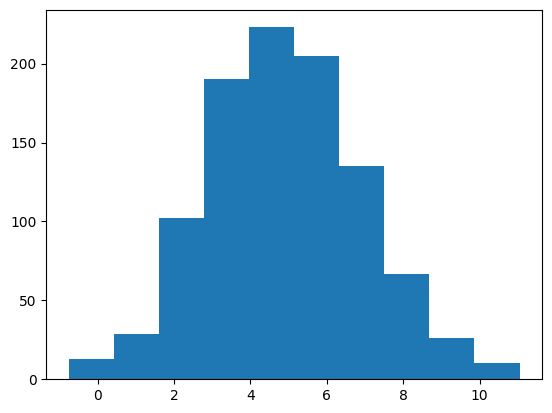

In [26]:
# another important function: gaussian!
# func.rvs(parameters) gives you random numbers based on func
# loc = mean, scale = sigma
nums = stats.norm.rvs(loc=5, scale=2, size=1000)
# visualization
plt.hist(nums)

## Fit a PDF to random numbers

fit parameter:  (np.float64(5.1343825489942745), np.float64(2.9598812044454137))


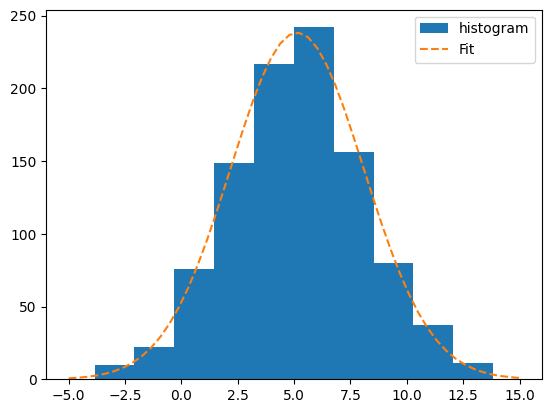

In [27]:
G = stats.norm # you need the 'un-fixed' function for fitting
G_frozen = G(loc=5, scale=3) # this is an 'rv_frozen' function, with fixed parameters

rn = G_frozen.rvs(size=1000) # random number generation with 'rvs' function (all stats functions have it)
h, edges, _ = plt.hist(rn, label="histogram")
fit = G.fit(rn)
print("fit parameter: ", fit)
x = np.linspace(-5, 15)
# we need to normalize the pdf to match the counts
y = G(*fit).pdf(x) * len(rn) * (edges[1] - edges[0])

plt.plot(x, y, "--", label="Fit")
plt.legend()